<a href="https://colab.research.google.com/github/JS2387/Text-mining-project/blob/main/climate_change_RNN_2ndsubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
!pip install Keras-Preprocessing
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
import keras as keras
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 


from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/the-reddit-climate-change-dataset-comments.csv"
data = pd.read_csv(path)

In [16]:
df = data.sample(frac = 0.025, random_state = 123)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113640 entries, 1857107 to 2312689
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   type            113640 non-null  object 
 1   id              113640 non-null  object 
 2   subreddit.id    113640 non-null  object 
 3   subreddit.name  113640 non-null  object 
 4   subreddit.nsfw  113640 non-null  bool   
 5   created_utc     113640 non-null  int64  
 6   permalink       113640 non-null  object 
 7   body            113640 non-null  object 
 8   sentiment       113640 non-null  float64
 9   score           113640 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 8.8+ MB


In [17]:
def create_label(sentiment):
    if sentiment < 0:
        return 0 # NEGATIVE SENTIMENT
    else:
        return 1 # POSITIVE SENTIMENT

In [18]:
df['label'] = df['sentiment'].apply(create_label)
df = df[['body', 'label']]
df = df.reset_index(drop = True)
df.head()

,body,label
0,A person's beliefs and needs shift based on ci...,1
1,I guess I don't understand what that has to do...,1
2,&gt;climate change will be way worse\n\nThere ...,0
3,The fire itself may have been caused by climat...,0
4,This has been a really interesting and informa...,1


In [12]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [13]:
nlp = spacy.load('en_core_web_lg')
nlp.Defaults.stop_words -= {"no", "not"}

def preprocess_text(text):
    doc = nlp(text)
    # Remove stop words and punctuation
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.like_url]
    return ' '.join(tokens)

In [19]:
df['body'] = df['body'].apply(preprocess_text)

In [20]:
df.body[525]

'point x number companies responsible basically climate change excuse means individual changes behavior pointless support structural change'

In [21]:
df.body.apply(lambda x:len(str(x).split())).max()

1256

In [22]:
#for testing re-runs
df1 = df.copy()

In [52]:
#resetting df if tests need to be repeated
df = df1.copy()
df = df.sample(frac=0.5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56820 entries, 31081 to 110143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    56820 non-null  object
 1   label   56820 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [53]:
#check labe distribution
df.label.value_counts()

1    29951
0    26869
Name: label, dtype: int64

# ML Classifiers

In [54]:
# Vectorize the comments
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df.body)
X.shape

Y = df.label

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 123, stratify = Y)

In [56]:
# Classifiers

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Dummy CLassifier
#DC = DummyClassifier(strategy = 'stratified') 

# Naive Bayes
clf_NB = MultinomialNB()

# Logisitic Regression
clf_LogR = LogisticRegression(max_iter=1000)

# Logistic Regression with CV
#clf_LogRCV = LogisticRegressionCV(max_iter = 1000)

# SGD
#clf_sgd = SGDClassifier(tol=1e-3)

# SVC
#clf_svc = SVC(decision_function_shape = 'ovo')

# Random Forest
#clf_RF = RandomForestClassifier(random_state=42, n_estimators=100)

# Adaptive Boosting
#clf_AdaB = AdaBoostClassifier(random_state=42, n_estimators=100, learning_rate=0.9)

# xGBoost
clf_xGB = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)

# Ensemble classifier
#ensemble_clf = VotingClassifier(estimators=[
#    ('RF_clf', clf_RF),
#    ('AdaB_clf', clf_AdaB),
#    ('xGB_clf', clf_xGB)
#    ], voting='soft')

In [57]:
# Naive bayes
clf_NB.fit(X_train, Y_train)
pred_NB = clf_NB.predict(X_test)
print(classification_report(Y_test, pred_NB))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71     13435
           1       0.76      0.66      0.70     14975

    accuracy                           0.71     28410
   macro avg       0.71      0.71      0.71     28410
weighted avg       0.71      0.71      0.71     28410



In [58]:
# Logisitic Regression
clf_LogR.fit(X_train, Y_train)
pred_LogR = clf_LogR.predict(X_test)
print(classification_report(Y_test, pred_LogR))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     13435
           1       0.80      0.84      0.82     14975

    accuracy                           0.80     28410
   macro avg       0.80      0.80      0.80     28410
weighted avg       0.80      0.80      0.80     28410



In [59]:
# xGBoost
clf_xGB.fit(X_train, Y_train)
pred_xGB = clf_xGB.predict(X_test)
print(classification_report(Y_test, pred_xGB))

              precision    recall  f1-score   support

           0       0.77      0.65      0.71     13435
           1       0.73      0.82      0.77     14975

    accuracy                           0.74     28410
   macro avg       0.75      0.74      0.74     28410
weighted avg       0.75      0.74      0.74     28410



# RNNs

## Tokenize

In [60]:
train_text, test_text, train_labels, test_labels = train_test_split(df['body'], df['label'], test_size=0.25, random_state=123)
train_text, valid_text, train_labels, valid_labels = train_test_split(train_text, train_labels, test_size=0.33, random_state=123)



In [61]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_text)

train_sequences = tokenizer.texts_to_sequences(train_text)
valid_sequences = tokenizer.texts_to_sequences(valid_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Pad the sequences
max_length = 100
train_data = pad_sequences(train_sequences, maxlen=max_length)
valid_data = pad_sequences(valid_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)

## Simple RNN

In [104]:
# A simpleRNN without any pretrained embeddings and one dense layer
model1 = Sequential()
model1.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model1.add(SimpleRNN(units=64, dropout=0.2))
model1.add(Dense(units=1, activation='sigmoid'))
    
# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model1.summary()

# Train the model
history1 = model1.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 128)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
447/447 [==============================] - 71s 154ms/step - loss: 0.6237 - accuracy: 0.6357 - val_loss: 0.5531 - val_accuracy: 0.7241
Epoch 2/10
447/447 [==============================] - 51s 114ms/step - loss: 0.4274 - accuracy: 0.8084 - val_loss: 0.5596 - val_accuracy: 0.7382
Epoch 3/10
447/447 [=

In [108]:
# Evaluate the model
y_pred = model1.predict(test_data)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
f1 = f1_score(test_labels, y_pred)

print("Test F1 score:", f1)

scores_model = []
scores_model.append({'Model': 'SimpleRNN','F1Score': f1})

444/444 [==============================] - 4s 10ms/step
Test F1 score: 0.7226845637583892


## Word Embeddings from GloVe

In [39]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [40]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip
!ls
!pwd

--2023-03-19 20:47:07--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-03-19 20:47:07--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.00MB/s    in 4m 44s  

2023-03-19 20:51:52 (5.10 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [41]:
# Define maximum sequence length and embedding dimension
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [42]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.twitter.27B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1193514it [00:37, 31872.09it/s]

Found 1193514 word vectors.


In [43]:
# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [66]:
# Convert text data to sequences and pad sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_text), maxlen=MAX_SEQUENCE_LENGTH)
X_valid_seq = pad_sequences(tokenizer.texts_to_sequences(valid_text), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_text), maxlen=MAX_SEQUENCE_LENGTH)


In [109]:
# Define and train an LSTM model
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, 
                     EMBEDDING_DIM, 
                     weights=[embedding_matrix], 
                     input_length=MAX_SEQUENCE_LENGTH, 
                     trainable=False))
model2.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model2.add(LSTM(units=64, dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

history2 = model2.fit(X_train_seq, train_labels, validation_data=(X_valid_seq, valid_labels), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 100)          8376300   
                                                                 
 lstm_17 (LSTM)              (None, 100, 128)          117248    
                                                                 
 lstm_18 (LSTM)              (None, 64)                49408     
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,543,021
Trainable params: 166,721
Non-trainable params: 8,376,300
_________________________________________________________________
Epoch 1/10
447/447 [==============================] - 10s 14ms/step - loss: 0.6853 - accuracy: 0.5488 - val_loss: 0.6804 - val_accuracy: 0.5785
Epoch 2/10
447/447 [=====

In [110]:
# Evaluate the model
y_pred = model2.predict(test_data)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
f1 = f1_score(test_labels, y_pred)

print("Test F1 score:", f1)

scores_model.append({'Model': 'LSTM with GloVe 27B.Twitter','F1Score': f1})

444/444 [==============================] - 2s 4ms/step
Test F1 score: 0.7509429514380009


In [82]:
scores_model

[{'Model': 'SimpleRNN', 'F1Score': 0.7883505569722186},
 {'Model': 'LSTM with GloVe 27B.Twitter', 'F1Score': 0.7340129749768305}]

## GRUs

In [102]:
%%time
# GRU with glove embeddings and 1 dense layer
model3 = Sequential()
model3.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model3.add(GRU(128, dropout = 0.2, return_sequences=True))
model3.add(GRU(64, dropout = 0.2))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model3.summary()

history3 = model3.fit(X_train_seq, train_labels, validation_data=(X_valid_seq, valid_labels), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          8376300   
                                                                 
 gru_14 (GRU)                (None, 100, 128)          88320     
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,501,933
Trainable params: 125,633
Non-trainable params: 8,376,300
_________________________________________________________________
Epoch 1/10
447/447 [==============================] - 9s 13ms/step - loss: 0.6869 - accuracy: 0.5453 - val_loss: 0.6805 - val_accuracy: 0.5606
Epoch 2/10
447/447 [======

In [111]:
# Evaluate the model
y_pred = model3.predict(test_data)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
f1 = f1_score(test_labels, y_pred)

print("Test F1 score:", f1)

scores_model.append({'Model': 'GRU with GloVe 27B.Twitter','F1Score': f1})

444/444 [==============================] - 2s 4ms/step
Test F1 score: 0.7448190535106712


# GRU with Batch Normalization

In [85]:
%%time
# GRU with glove embeddings and 1 dense layer and batch normalization
model4 = Sequential()
model4.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model4.add(BatchNormalization())
model4.add(GRU(128, dropout = 0.2, return_sequences=True))
model4.add(GRU(64, dropout = 0.2))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model4.summary()

history4 = model4.fit(X_train_seq, train_labels, validation_data=(X_valid_seq, valid_labels), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 100)          8376300   
                                                                 
 batch_normalization (BatchN  (None, 100, 100)         400       
 ormalization)                                                   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          88320     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,502,333
Trainable params: 125,833
Non-trainable params: 8,376,500
_____________________________________

In [112]:
# Evaluate the model
y_pred = model4.predict(test_data)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
f1 = f1_score(test_labels, y_pred)

print("Test F1 score:", f1)

scores_model.append({'Model': 'GRU-Batch Normalization with GloVe 27B.Twitter','F1Score': f1})

444/444 [==============================] - 2s 4ms/step
Test F1 score: 0.7692027666545322


## Bi-Directional LSTM

In [88]:
%%time
# A simple bidirectional LSTM with glove embeddings and one dense layer
model5 = Sequential()
model5.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model5.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.2)))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model5.summary()

history5 = model5.fit(X_train_seq, train_labels, validation_data=(X_valid_seq, valid_labels), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          8376300   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 8,775,277
Trainable params: 398,977
Non-trainable params: 8,376,300
_________________________________________________________________
Epoch 1/10
447/447 [=================

In [113]:
# Evaluate the model
y_pred = model5.predict(test_data)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
f1 = f1_score(test_labels, y_pred)

print("Test F1 score:", f1)

scores_model.append({'Model': 'Bi_directional LSTM with GloVe 27B.Twitter','F1Score': f1})

444/444 [==============================] - 3s 7ms/step
Test F1 score: 0.7043416370106761


In [114]:
scores_model

[{'Model': 'SimpleRNN', 'F1Score': 0.7226845637583892},
 {'Model': 'LSTM with GloVe 27B.Twitter', 'F1Score': 0.7509429514380009},
 {'Model': 'GRU with GloVe 27B.Twitter', 'F1Score': 0.7448190535106712},
 {'Model': 'GRU-Batch Normalization with GloVe 27B.Twitter',
  'F1Score': 0.7692027666545322},
 {'Model': 'Bi_directional LSTM with GloVe 27B.Twitter',
  'F1Score': 0.7043416370106761}]

# Collect all Network Architectures

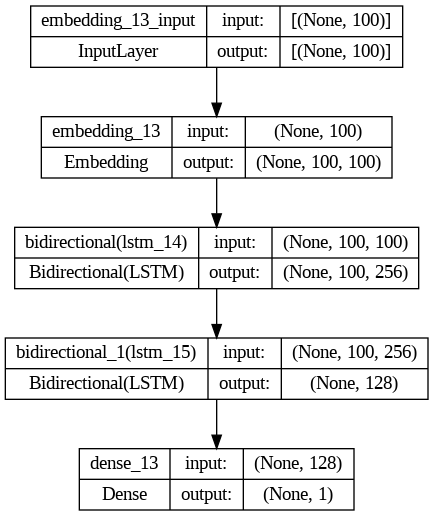

In [115]:
tf.keras.utils.plot_model(model1, to_file='Simple_RNN.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model2, to_file='Deep_LSTM_with_GloVe_embeddings.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model3, to_file='Deep_GRU_with_GloVe_embeddings.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model4, to_file='Deep_GRU_with_BatchNormalization_with_GloVe_embeddings.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model5, to_file='Deep_Bi-LSTM_with_GloVe_embeddings.png', show_shapes=True, show_layer_names=True)

# Redo with GloVe, ELMo and BERT

In [24]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 27.9 MB/s eta 0:00:00


In [50]:
import torch
from transformers import TFBertModel, BertTokenizer

In [67]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [106]:
# Tokenize the text data using the tokenizer
max_length = 256
X = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in df['body']]
Y = df['label'].values

# Convert the input sequences and labels to TensorFlow tensors
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)

In [114]:
# Split the data into training and validation sets
train_size = int(0.5 * len(df))
train_X, val_X = X[:train_size], X[train_size:]
train_Y, val_Y = Y[:train_size], Y[train_size:]
#test_size = int(0.5 * len(val_X))
#val_X, test_X = val_X[:test_size], val_X[test_size:]
#val_Y, test_Y = val_Y[:test_size], val_Y[test_size:]

In [115]:
# Define the model architecture
input_layer = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_layer')
embedding_layer = bert_model(input_layer)[0]
pooling_layer = tf.keras.layers.GlobalMaxPool1D()(embedding_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(pooling_layer)
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_X, train_Y, epochs=3, batch_size=64, validation_data=(val_X, val_Y))

Epoch 1/3


711/711 [==============================] - 381s 477ms/step - loss: 0.6922 - accuracy: 0.5237 - val_loss: 0.7007 - val_accuracy: 0.4715
Epoch 2/3
711/711 [==============================] - 335s 472ms/step - loss: 0.6920 - accuracy: 0.5260 - val_loss: 0.6938 - val_accuracy: 0.4715
Epoch 3/3
711/711 [==============================] - 335s 472ms/step - loss: 0.6920 - accuracy: 0.5260 - val_loss: 0.6920 - val_accuracy: 0.5285


In [116]:
# Evaluate model on test set
y_pred = np.round(model.predict(test_X))
print(classification_report(test_Y, y_pred))

711/711 [==============================] - 53s 70ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10746
           1       0.53      1.00      0.69     11979

    accuracy                           0.53     22725
   macro avg       0.26      0.50      0.35     22725
weighted avg       0.28      0.53      0.36     22725



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

NameError: ignored